## Prerequisites
- Basic comfort with python, some linear algebra, some data science
- Download & Install Docker: https://docs.docker.com/install/
- Download ML4D_BroadE.zip from Google Drive: 

# Welcome to ML4D BroadE!

### Agenda
10:00-10:05: Intro Videos, Demos and Downloads 

10:05-10:30: Run docker jupyter server and open broad.ipynb and run first cell

10:30-10:45: Fundamental ML (linear and logistic regression, SGD, depth and interpretation)

10:45-11:00: Train models on well-studied datasets (MNIST, CIFAR10)

11:00-11:30: ML4CVD Abstractions: Tensorization, TensorMaps and the ModelFactory

11:30-11:45: Coffee Break, Discussion and Data Exploration videos (groups coalesce: feature not bug)

11:45-11:55: Neurologist pep Talk

11:55-12:30: Defining TensorMaps on MNIST, Cifar and BiomedData sets.

12:15-12:30: Training models on the datasets

12:30-12:45: Saliency Maps  on BiomedData sets

12:45-12:59: Discussion and TensorMaps on your data


### Linear Regression
We explore machine learning on Bio medical data using Cloud computing, Python, Tensorflow, and the ML4CVD codebase.

We will start with linear regression.  Our model is a vector, one weight for each input feature, and a single bias weight.

\begin{equation}
y = xw + b
\end{equation}

For notational convenience absorb the bias term into the weight vector by adding a 1 to the input data matrix $X$

\begin{equation}
y = [\textbf{1}, X][b, \textbf{w}]^T
\end{equation}

#### The Dense Layer is Matrix (Tensor) Multiplication
![Matrix Multiplication](https://www.mathwarehouse.com/algebra/matrix/images/matrix-multiplication/how-to-multiply-2-matrices-demo.gif)

In [1]:
# Import:
import os
import sys
import pickle
import random
from typing import List, Dict, Callable
from collections import defaultdict, Counter

import csv
import gzip
import h5py
import shutil
import zipfile
import pydicom
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

from ml4cvd.defines import StorageType
from ml4cvd.arguments import parse_args, TMAPS, _get_tmap
from ml4cvd.TensorMap import TensorMap, Interpretation
from ml4cvd.tensor_generators import test_train_valid_tensor_generators
from ml4cvd.models import train_model_from_generators, make_multimodal_multitask_model, _inspect_model
from ml4cvd.recipes import test_multimodal_multitask, train_multimodal_multitask

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [14]:
def linear_regression():
    samples = 40
    real_weight = 2.0
    real_bias = 0.5
    x = np.linspace(-1, 1, samples)
    y = real_weight*x + real_bias + (np.random.randn(*x.shape) * 0.1)

    linear_model = Sequential()
    linear_model.add(Dense(1, input_dim=1))
    linear_model.compile(loss='mse', optimizer='sgd')
    linear_model.summary()
    linear_model.fit(x, y, batch_size=1, epochs=10)

    learned_slope = linear_model.get_weights()[0][0][0]
    learned_bias = linear_model.get_weights()[1][0]
    print('Learned slope:',  learned_slope, 'real slope:', real_weight, 'learned bias:', learned_bias, 'real bias:', real_bias)

    plt.plot(x, y)
    plt.plot([-1,1], [-learned_slope+learned_bias, learned_slope+learned_bias], 'r')
    plt.show()
    print('Linear Regression complete!')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
40/40 [==============================] - 5s 114ms/step - loss: 1.2588
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.6750
Epoch 3/10
40/40 [==============================] - 0s 1ms/step - loss: 0.3804
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2215
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.1328
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.0828
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 8/10
40/40 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 9/10
40/40 [==

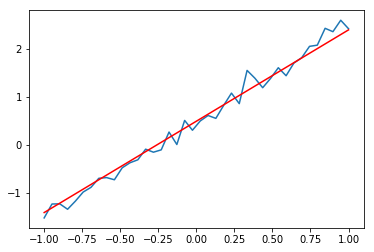

Linear Regression complete!


In [15]:
linear_regression()

## Now Logistic Regression:
We take the real-valued predictions from linear regression and squish them with a sigmoid.

\begin{equation}
\textbf{y} = \sigma(X\textbf{w} + b)
\end{equation}

where 
\begin{equation}
\sigma(x) = \frac{e^x}{1+e^x} = \frac{1}{1+e^{-x}}
\end{equation}

In [2]:
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(math.exp(item)/(1+math.exp(item)))
    return a

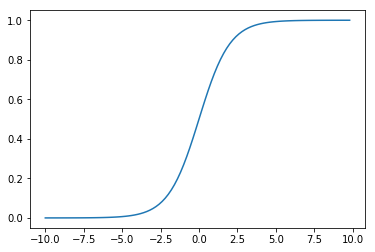

In [3]:
x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.show()

In [16]:
def logistic_regression():
    train, test, valid = load_data('mnist.pkl.gz')

    epochs = 1000
    num_labels = 10
    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)

    logistic_model = Sequential()
    logistic_model.add(Dense(num_labels, activation='softmax', input_dim=784, name='mnist_templates'))
    logistic_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    logistic_model.summary()
    templates = logistic_model.layers[0].get_weights()[0]
    plot_templates(templates, 0)
    print('weights shape:', templates.shape)

    for e in range(epochs):
        trainidx = random.sample(range(0, train[0].shape[0]), 8192)
        x_batch = train[0][trainidx,:]
        y_batch = train_y[trainidx]
        logistic_model.train_on_batch(x_batch, y_batch)
        if e % 100 == 0:
            plot_templates(logistic_model.layers[0].get_weights()[0], e)
            print('Logistic Model test set loss and accuracy:', logistic_model.evaluate(test[0], test_y), 'at epoch', e)


def plot_templates(templates, epoch):
    n = 10
    templates = templates.reshape((28,28,n))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        ax = plt.subplot(2, 5, i+1)		
        plt.imshow(templates[:, :, i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plot_name = "./regression_example/mnist_templates_"+str(epoch)+".png"
    if not os.path.exists(os.path.dirname(plot_name)):
        os.makedirs(os.path.dirname(plot_name))		
    plt.savefig(plot_name)


def make_one_hot(y, num_labels):
    ohy = np.zeros((len(y), num_labels))
    for i in range(0, len(y)):
        ohy[i][y[i]] = 1.0
    return ohy


def load_data(dataset):
    ''' Loads the dataset
    :type dataset: string
    :param dataset: the path to the dataset (here MNIST)
    '''

    #############
    # LOAD DATA #
    #############

    # Download the MNIST dataset if it is not present
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join("data", dataset)
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from urllib.request import urlretrieve
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        )
        print('Downloading data from %s' % origin)
        if not os.path.exists(os.path.dirname(dataset)):
            os.makedirs(os.path.dirname(dataset))	
        urlretrieve(origin, dataset)

    print('loading data...')

    # Load the dataset
    f = gzip.open(dataset, 'rb')
    if sys.version_info[0] == 3:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        train_set, valid_set, test_set = u.load()
    else:
        train_set, valid_set, test_set = pickle.load(f)

    f.close()

    return train_set, valid_set, test_set

## Cross Entropy Loss:
Our favorite loss function for categorical data.
\begin{equation}
L(true, model) = -\sum_{x\in\mathcal{X}} true(x)\, \log model(x)
\end{equation}

Binary cross entropy with $N$ data points $x$ each with a binary label: 
\begin{equation}
true(x) \in \{0, 1\} \\
L(true, model) = -\frac{1}{N}\sum^N_{i=1} true(x_i)\log(model(x_i)) + (1-true(x_i))log(1-model(x_i))
\end{equation}

This is the Kullback Leibler divergence between the true distribution and the predicted. 
This function emerges in many fields as diverse as probability, information theory, and physics.
What is the information difference between the truth and our model?  How much data do I lose by replacing the truth with the model's predictions. What is the temperature difference between my predictions and the truth?!

Categorical cross entropy with $K$ different classes or labels: 
\begin{equation}
true(x) \in \{0, 1, 2, ..., K\} \\
L(true, model) = -\frac{1}{N}\sum^N_{i=1}\sum^K_{j=1} y_{ik}\log(q_k(x_i)))
\end{equation}

loading data...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist_templates (Dense)      (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
weights shape: (784, 10)
10000/10000 [==============================] - 0s 49us/step
Logistic Model test set loss and accuracy: [2.4515818836212158, 0.074] at epoch 0
10000/10000 [==============================] - 0s 35us/step
Logistic Model test set loss and accuracy: [1.6020798934936524, 0.6585] at epoch 100
10000/10000 [==============================] - 0s 35us/step
Logistic Model test set loss and accuracy: [1.2100174451828003, 0.7802] at epoch 200
10000/10000 [==============================] - 0s 35us/step
Logistic Model test set loss and accuracy: [0.9972333906173706, 0.816] at epoch 300
10000/10000 [===============

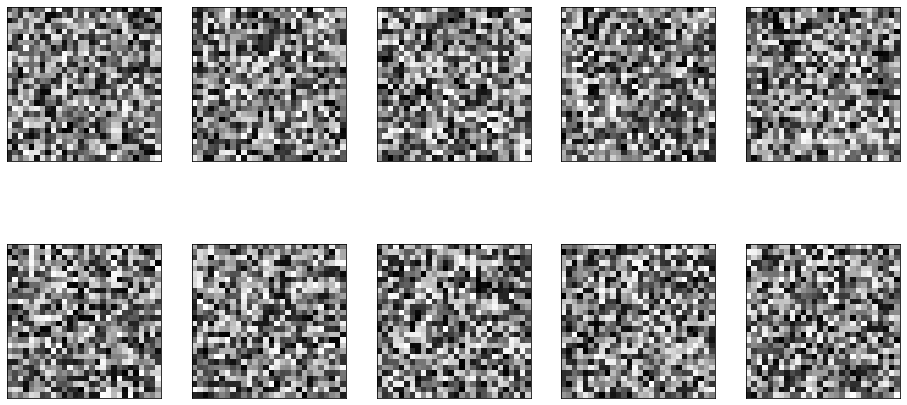

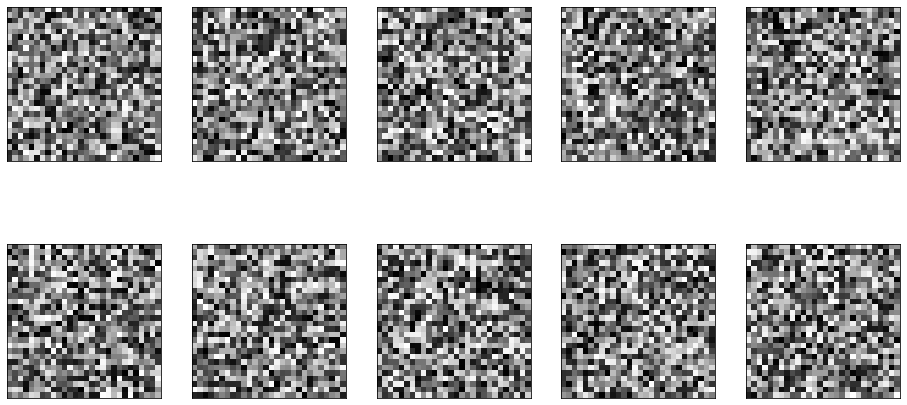

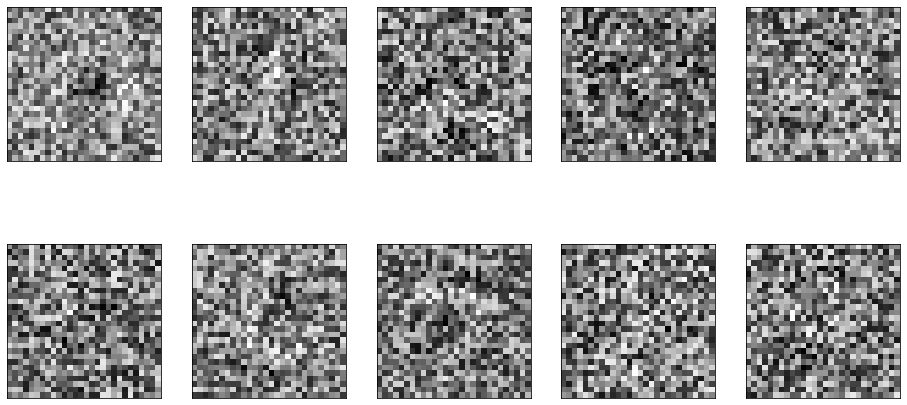

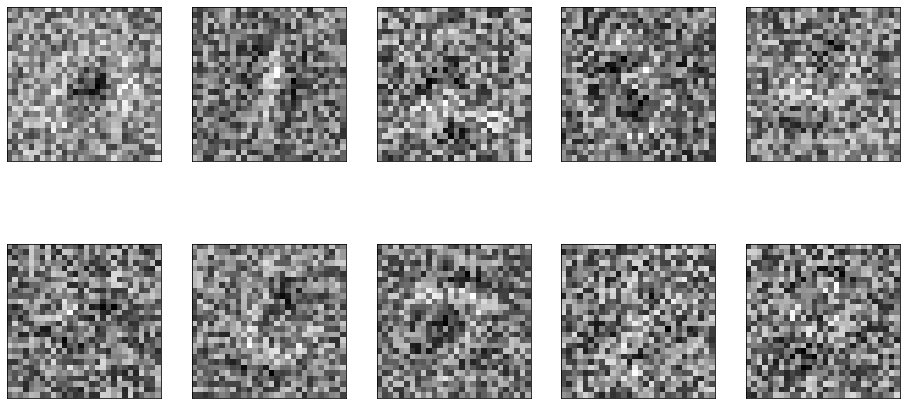

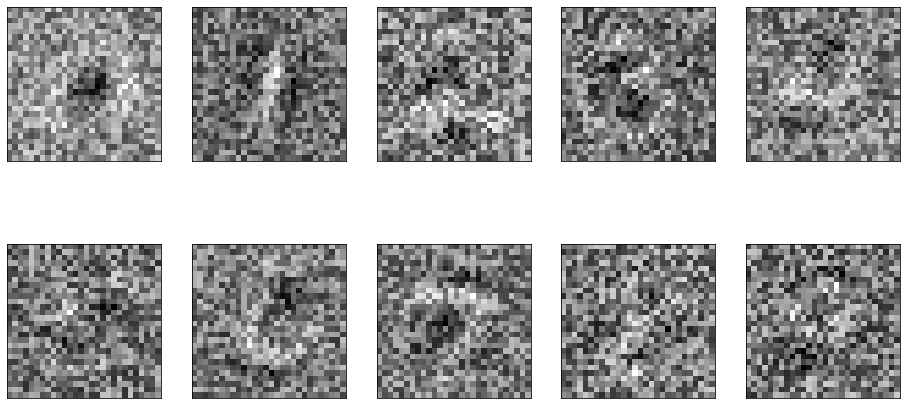

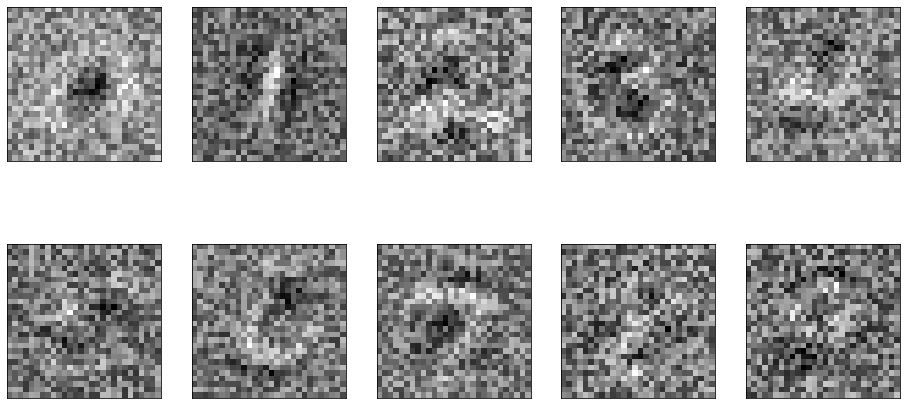

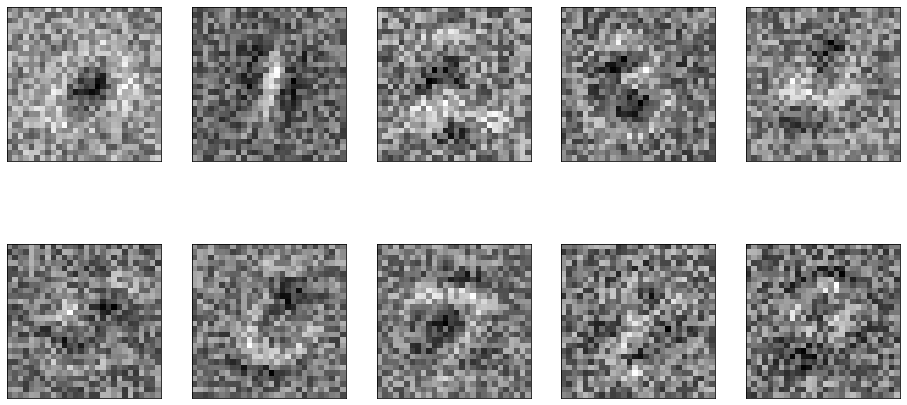

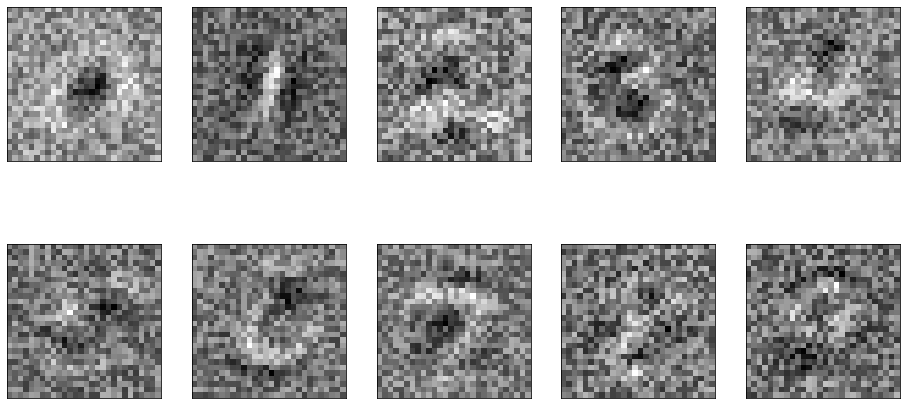

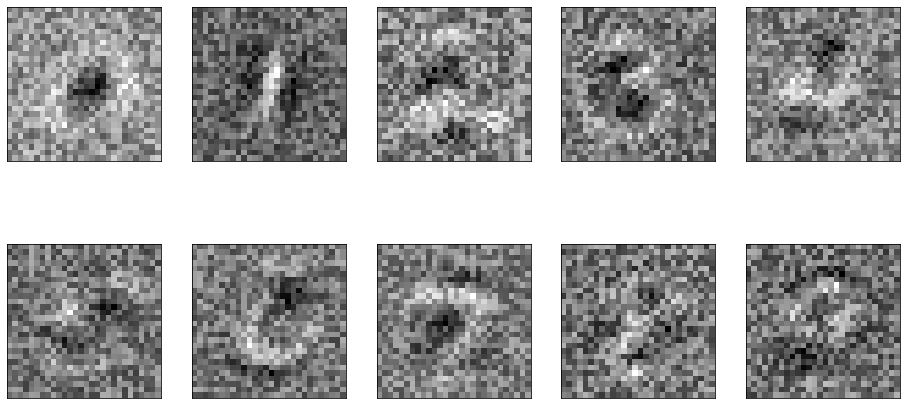

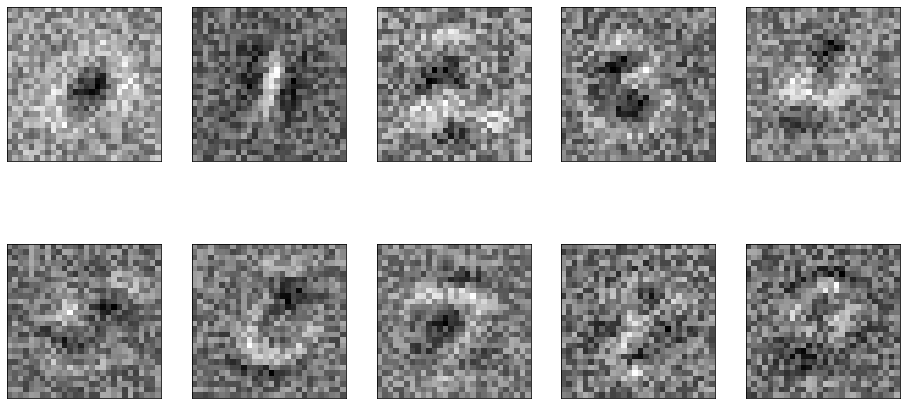

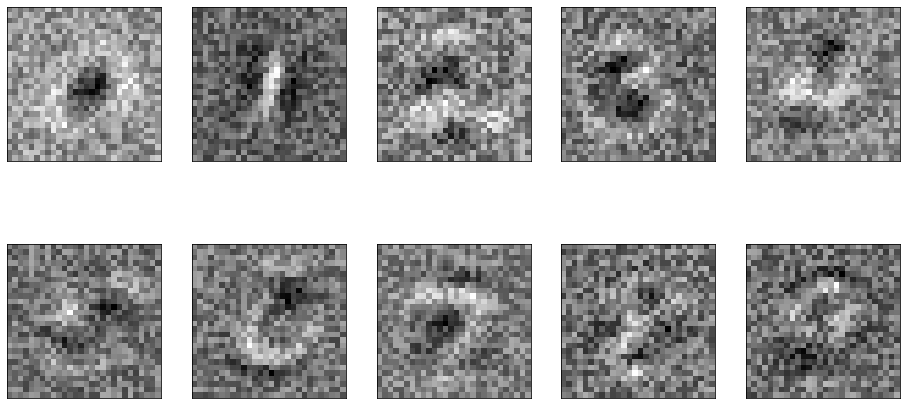

In [17]:
logistic_regression()

# Deep Models: "Hidden" Layers and The MultiLayerPerceptron

In [14]:
def multilayer_perceptron():
    train, test, valid = load_data('mnist.pkl.gz')

    num_labels = 10
    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)

    mlp_model = Sequential()
    mlp_model.add(Dense(500, activation='relu', input_dim=784))
    mlp_model.add(Dense(num_labels, activation='softmax'))
    mlp_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    mlp_model.summary()
    mlp_model.fit(train[0], train_y, validation_data=(valid[0],valid_y), batch_size=32, epochs=3)
    print('Multilayer Perceptron trained. Test set loss and accuracy:', mlp_model.evaluate(test[0], test_y))

multilayer_perceptron()

loading data...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_18 (Dense)             (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 5s 91us/step - loss: 0.6542 - acc: 0.8428 - val_loss: 0.3591 - val_acc: 0.9039
Epoch 2/3
50000/50000 [==============================] - 4s 82us/step - loss: 0.3432 - acc: 0.9052 - val_loss: 0.2915 - val_acc: 0.9182
Epoch 3/3
10000/10000 [==============================] - 0s 35us/step
Multilayer Perceptron trained. Test set loss and accuracy: [0.2536626645088196, 0.9286]


# Convolutions Flip, Slide, Multiply, Add
Convolutions look for their kernel in a larger signal.

In convolution, you always and only find what you're looking with.

Convolution and cross correlation are deeply related:

\begin{equation}
f(t) \circledast g(t) \triangleq\ \int_{-\infty}^\infty f(\tau) g(t - \tau) \, d\tau. = \int_{-\infty}^\infty f(t-\tau) g(\tau)\, d\tau.
\end{equation}



![title](https://upload.wikimedia.org/wikipedia/commons/2/21/Comparison_convolution_correlation.svg)

loading data...
(50000, 784)
(50000, 28, 28, 1)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
flatten_11 (Flatten)         (None, 15488)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                247824    
_________________________________________________________________
dense_20 (Dense)             (None, 10)                170       
Total params: 266,810
Trainable params: 266,810
Non-trainable params: 0

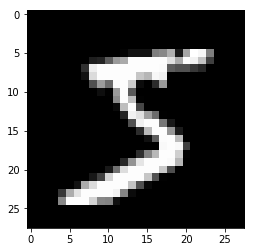

In [15]:
def convolutional_neural_network(filters=32, kernel_size=(3,3), padding='valid'):
    train, test, valid = load_data('mnist.pkl.gz')

    num_labels = 10
    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)
    print(train[0].shape)
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    mnist_valid = valid[0].reshape((-1, 28, 28, 1))
    mnist_test = test[0].reshape((-1, 28, 28, 1))
    plt.imshow(mnist_images[0, ..., 0], cmap='gray')
    print(mnist_images.shape)
    cnn_model = Sequential()
    cnn_model.add(Conv2D(input_shape=(28, 28, 1), filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(16, activation='relu'))
    cnn_model.add(Dense(num_labels, activation='softmax'))
    cnn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    cnn_model.summary()
    cnn_model.fit(mnist_images, train_y, validation_data=(mnist_valid, valid_y), batch_size=32, epochs=3)
    
    print('Convolutional Neural Network trained. Test set loss and accuracy:', cnn_model.evaluate(mnist_test, test_y))

convolutional_neural_network()

# Why (and When!) is Convolution Helpful?
- Decouples input size from model size
- Translationally Equivariant (Not Invariant), so we can find features wherever they might occur in the signal
- Local structure is often informative
- But not always! (eg Tabular data)

# ML4CVD Cosmology:  Tensors all the way down.


# ML4CVD Abstractions: Tensorization, the TensorMap, and the ModelFactory

## Tensorization
Tensorization is the process of gathering any number of input files and consolidating them into compressed HD5 files.  We tend to make one HD5 file per sample in the study.  The files contain the raw data and labels we will use to train models.  It tends to be efficient to separate tensor construction from model training.

In [1]:
def parse_dicoms(dicom_folder, stats):
    dcm_file = ''
    my_stats = Counter()
    series = defaultdict(list)
    for root, _, files in os.walk(dicom_folder):
        for name in files:
            dcm_file = os.path.join(root, name)
            if not dcm_file.endswith('.dcm'):
                continue
            try:
                dcm = pydicom.read_file(dcm_file)
                my_stats[f'Shape {dcm.pixel_array.shape}'] += 1
                my_stats['count'] += 1
                my_stats[f'Series Number {dcm.SeriesNumber}'] += 1
                my_stats[f'Series Description {dcm.SeriesDescription}'] += 1
                my_stats[f'Pixel spacing{dcm.PixelSpacing}'] += 1
                series[dcm.SeriesDescription.lower().replace(' ', '_')].append(dcm)
            except:
                my_stats['got an error'] += 1
                break
    print(f'\n\nAt DICOM {dcm_file}')
    for k in my_stats:
        print(f'{k} has {my_stats[k]}') 
    
    try:
        tensors = {}
        for k in series:
            tensors[k] = np.zeros((512, 512, len(series[k])))
            for dcm in series[k]:
                tensors[k][..., dcm.InstanceNumber-1] = dcm.pixel_array
    except:
        my_stats['got a tensorization error'] += 1
            
    stats.update(my_stats)
    return tensors

In [2]:
def tensorize_qure_ai_dicoms(zip_folder, dicom_folder, hd5_folder):
    raw_data = {}
    stats = Counter()
    if not os.path.exists(dicom_folder):
        os.makedirs(dicom_folder)
    if not os.path.exists(hd5_folder):
        os.makedirs(hd5_folder)    
    for z in os.listdir(zip_folder):
        if os.path.exists(os.path.join(hd5_folder, z.replace('.zip', '.hd5'))):
            continue
        with zipfile.ZipFile(zip_folder + z, "r") as zip_ref:
            zip_ref.extractall(dicom_folder)
            tensors = parse_dicoms(dicom_folder, stats)
            with h5py.File(os.path.join(hd5_folder, z.replace('.zip', '.hd5')), 'w') as hd5:
                for t in tensors:
                    hd5.create_dataset(t, data=tensors[t], compression='gzip')
        shutil.rmtree(dicom_folder)

    print('\n\n Full stats below:')
    for k in stats:
        print(f'{k} has {stats[k]}')


In [5]:
def tensorize_qure_ai_reads(read_file, hd5_folder):
    with open(read_file, 'r') as my_csv:
        lol = list(csv.reader(my_csv, delimiter=','))
        header = [h.replace(':', '_').lower() for h in lol[0]]
        print(f'header is {header}')
        for row in lol[1:]:
            try:
                with h5py.File(f'{hd5_folder}{row[0]}.hd5', 'a') as hd5:
                    for i, value in enumerate(row[2:]):
                        hd5.create_dataset(header[i+2], data=[int(value)])
            except:
                print(f'Could not open {row[0]}')

## TensorMaps
The critical data structure in the ML4CVD codebase is the TensorMap.
This abstraction provides a way to translate ***any*** kind of input data, into structured numeric tensors with clear semantics for interpretation and modeling.  TensorMaps guarantee a shape, a way to consturct tensors of that shape from the HD5 files created during tensorization and a meaning to the values in the tensor that the TensorMap yields.

In [2]:
mnist_image = TensorMap('mnist_image', Interpretation.CONTINUOUS, shape=(28, 28))
mnist_image = TensorMap('mnist_image', Interpretation.CONTINUOUS, shape=(28, 28, 1))

mnist_channel_map = {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'zero': 4, 'zero': 5, 
                     'six': 6, 'seven': 9, 'eight': 8, 'nine': 9}

mnist_class = TensorMap('mnist_class', Interpretation.CATEGORICAL, shape=(10,), channel_map=mnist_channel_map)

In [3]:
cifar_image = TensorMap('cifar_image', Interpretation.CONTINUOUS, shape=(32, 32, 3))

cifar_channel_map = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 
                     'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

cifar_class = TensorMap('cifar_class', Interpretation.CATEGORICAL, shape=(10,), channel_map=cifar_channel_map)

In [4]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap]):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    if os.path.isfile(path):
        with h5py.File(path, 'r') as hd5:
            for tmap in tmaps:
                try:
                    result_dict[tmap] = tmap.tensor_from_file(tmap, hd5)
                except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                    continue
    return result_dict

In [5]:
def plot_array_3d(a):
    slice_axis = -1
    sides = int(np.ceil(np.sqrt(a.shape[slice_axis])))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    print(a.shape)
    vmin = np.min(a)
    vmax = np.max(a)
    for i in range(a.shape[slice_axis]):
        axes[i//sides, i%sides].imshow(a[..., i], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i//sides, i%sides].set_yticklabels([])
        axes[i//sides, i%sides].set_xticklabels([])

In [2]:
def slice_from_hd5(tm, hd5, dependents={}):
    for k in np.random.permutation(list(hd5.keys())):
        if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] < 50:
            random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
            random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
            random_slices = np.clip(random_slices, 3000, 10000)
            return random_slices
    raise ValueError('No CT slices in HD5')
   
TMAPS['slice_map'] = TensorMap('slice_map', shape=(512, 512, 1), tensor_from_file=slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['slice_map5'] = TensorMap('slice_map5', shape=(512, 512, 5), tensor_from_file=slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['slice_map25'] = TensorMap('slice_map25', shape=(512, 512, 25), tensor_from_file=slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})

slice_map25 has (512, 512, 25)
(512, 512, 25)


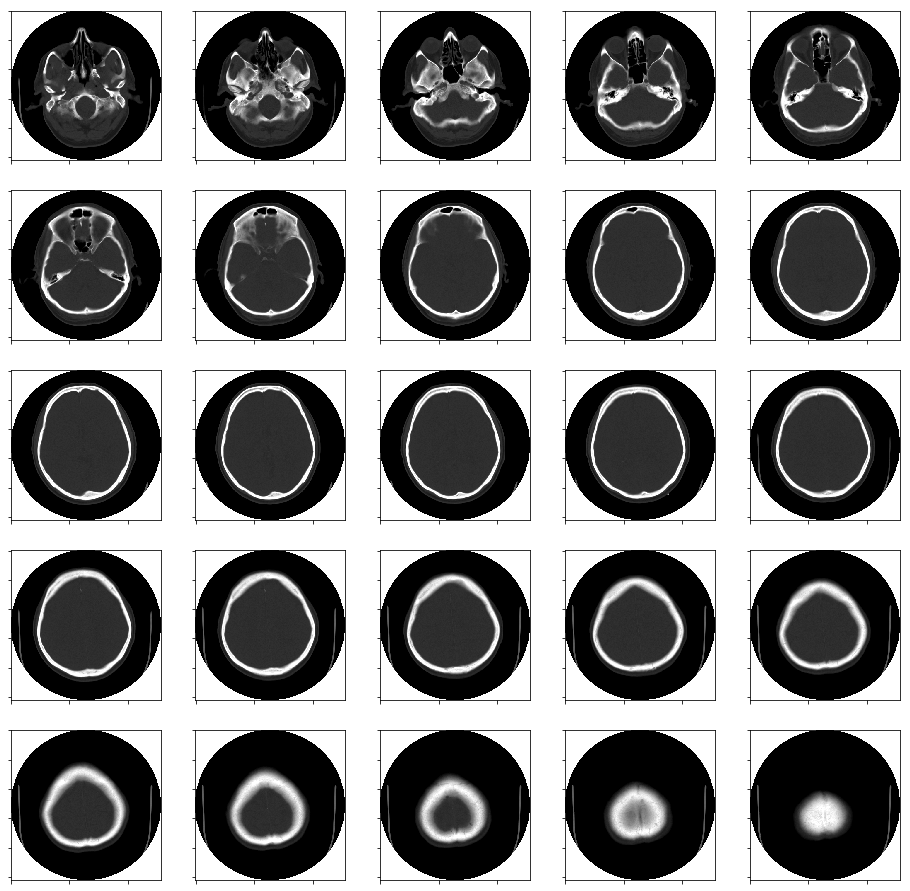

In [7]:
t = tmaps_by_sample_id('/home/sam/ct_brains/', 'CQ500-CT-222', [ _get_tmap('slice_map25')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])

In [3]:
def thin_slice_from_hd5(tm, hd5, dependents={}):
    for k in np.random.permutation(list(hd5.keys())):
        if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] > 100:
            random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
            random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
            random_slices = np.clip(random_slices, 3000, 10000)
            return random_slices
    raise ValueError('No CT slices in HD5')
    
TMAPS['thin_slice_map16'] = TensorMap('thin_slice_map16', shape=(512, 512, 16), tensor_from_file=thin_slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['thin_slice_map50'] = TensorMap('thin_slice_map50', shape=(512, 512, 50), tensor_from_file=thin_slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['thin_slice_map200'] = TensorMap('thin_slice_map200', shape=(512, 512, 200), tensor_from_file=thin_slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})

thin_slice_map50 has (512, 512, 50)
(512, 512, 50)


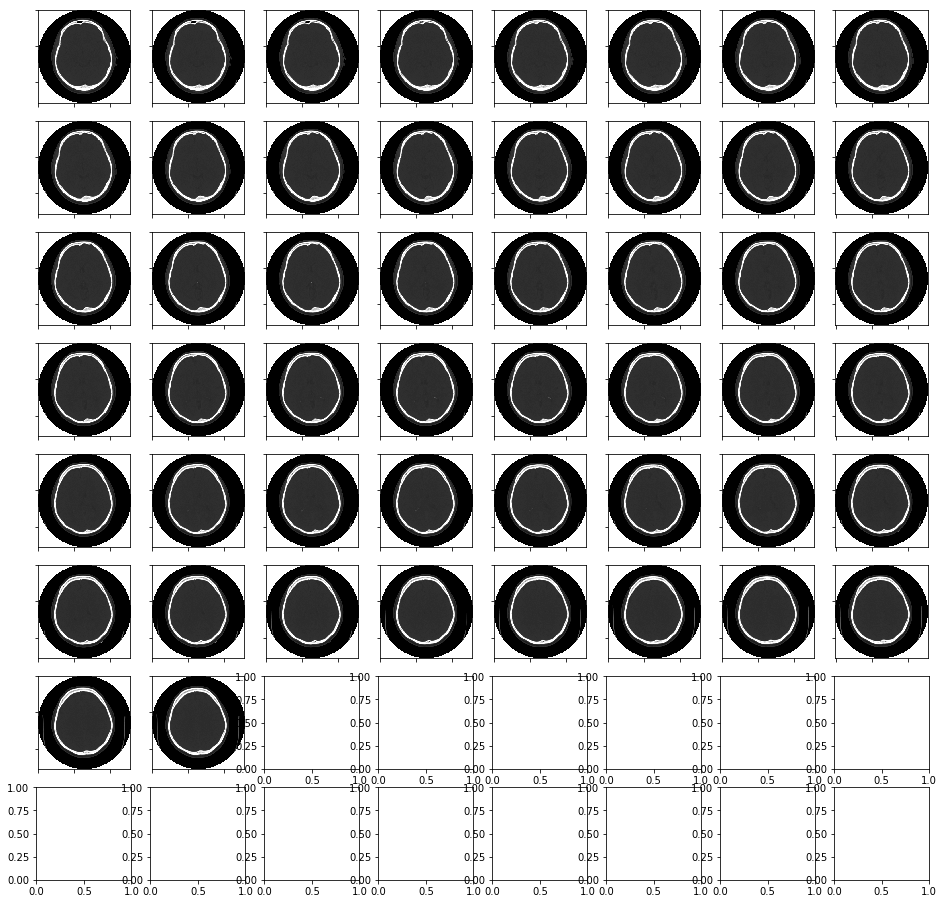

In [9]:
t = tmaps_by_sample_id('/home/sam/ct_brains/', 'CQ500-CT-222', [ _get_tmap('thin_slice_map50')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])   

In [4]:
TMAPS['r1_fracture'] = TensorMap('r1_fracture', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_fracture': 0, 'r1_fracture': 1})
TMAPS['r2_fracture'] = TensorMap('r2_fracture', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_fracture': 0, 'r2_fracture': 1})
TMAPS['r3_fracture'] = TensorMap('r3_fracture', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_fracture': 0, 'r3_fracture': 1})

In [5]:
TMAPS['r1_ich'] = TensorMap('r1_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_ich': 0, 'r1_ich': 1})
TMAPS['r2_ich'] = TensorMap('r2_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_ich': 0, 'r2_ich': 1})
TMAPS['r3_ich'] = TensorMap('r3_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_ich': 0, 'r3_ich': 1})

In [6]:
TMAPS['r1_iph'] = TensorMap('r1_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_iph': 0, 'r1_iph': 1})
TMAPS['r2_iph'] = TensorMap('r2_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_iph': 0, 'r2_iph': 1})
TMAPS['r3_iph'] = TensorMap('r3_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_iph': 0, 'r3_iph': 1})

In [7]:
TMAPS['r1_midlineshift'] = TensorMap('r1_midlineshift', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_midlineshift': 0, 'r1_midlineshift': 1})
TMAPS['r2_midlineshift'] = TensorMap('r2_midlineshift', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_midlineshift': 0, 'r2_midlineshift': 1})
TMAPS['r3_midlineshift'] = TensorMap('r3_midlineshift', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_midlineshift': 0, 'r3_midlineshift': 1})

In [8]:
TMAPS['r1_sah'] = TensorMap('r1_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_sah': 0, 'r1_sah': 1})
TMAPS['r2_sah'] = TensorMap('r2_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_sah': 0, 'r2_sah': 1})
TMAPS['r3_sah'] = TensorMap('r3_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_sah': 0, 'r3_sah': 1})

In [9]:
TMAPS['r1_sdh'] = TensorMap('r1_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_sdh': 0, 'r1_sdh': 1})
TMAPS['r2_sdh'] = TensorMap('r2_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_sdh': 0, 'r2_sdh': 1})
TMAPS['r3_sdh'] = TensorMap('r3_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_sdh': 0, 'r3_sdh': 1})

In [10]:
TMAPS['r1_chronicbleed'] = TensorMap('r1_chronicbleed', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_chronicbleed': 0, 'r1_chronicbleed': 1})
TMAPS['r2_chronicbleed'] = TensorMap('r2_chronicbleed', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_chronicbleed': 0, 'r2_chronicbleed': 1})
TMAPS['r3_chronicbleed'] = TensorMap('r3_chronicbleed', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_chronicbleed': 0, 'r3_chronicbleed': 1})

# The Model Factory
The function ***make_multimodal_multitask_model()*** takes lists of TensorMaps and connects them with intelligent goo.
### Model Architectures
- Classification
- Regression
- Multitask
- Multimodal
- Multimodal Multitask
- Autoencoders

In [11]:
sys.argv = ['train', 
            '--tensors', '/home/sam/ct_brains/', 
            '--input_tensors', 'slice_map',
            '--output_tensors', 'r1_midlineshift',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_model.png')

2020-02-26 08:22:34,063 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-26_08-22_0.log.
2020-02-26 08:22:34,064 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /home/sam/ct_brains/ --input_tensors slice_map --output_tensors r1_midlineshift --num_workers 0 --cache_size 0



2020-02-26 08:22:34,065 - arguments:207 - INFO - Total TensorMaps:427 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=0.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dropout=0.0, conv_layers=[3

Epoch 1/1
2020-02-26 08:22:37,377 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-26 08:22:37,379 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.000 GB.
2020-02-26 08:22:37,380 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-26 08:22:37,518 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.000 GB.
2020-02-26 08:22:44,990 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 55
	Generator looped & shuffled over 88 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 176 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	7.61 seconds elapsed.


/home/sam/ml/ml4cvd/tensor_generators.py:201: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(list(self.files_seen.values()) or [0]) / self.nrows


2020-02-26 08:22:52,129 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 2:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 52
	Generator looped & shuffled over 88 paths.
	35 tensors were presented.
	The cache holds 0 out of a possible 176 tensors and is nan% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	7.14 seconds elapsed.
1/1 [==============================] - 19s 19s/step - loss: 0.6903 - categorical_accuracy: 0.7500 - no_r1_midlineshift_precision: 0.5714 - r1_midlineshift_precision: 0.0000e+00 - no_r1_midlineshift_recall: 0.3333 - r1_midlineshift_recall: 0.0000e+00 - val_loss: 0.6583 - val_categorical_accuracy: 0.8750 - val_no_r1_midlineshift_precision: 0.8750 - val_r1_midlineshift_precision: 0.0000e+00 - val_no_r1_midlineshift_recall: 1.0000 - val_r1_midlineshift_recall: 0.0000e+00
2020-02-26 08:22:56,785 - models:1137 - INFO - Spent:21.31 seconds training, Samples trained on:1 

![My First Model Architecture](./my_firt_model.png)

In [12]:
sys.argv = ['train', 
            '--tensors', '/home/sam/ct_brains/', 
            '--input_tensors', 'slice_map',
            '--output_tensors', 'r1_midlineshift', 'r2_midlineshift', 'r3_midlineshift',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_multitask_model.png')

2020-02-26 08:37:04,948 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-26_08-37_0.log.
2020-02-26 08:37:04,950 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /home/sam/ct_brains/ --input_tensors slice_map --output_tensors r1_midlineshift r2_midlineshift r3_midlineshift --num_workers 0



2020-02-26 08:37:04,952 - arguments:207 - INFO - Total TensorMaps:427 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=437500000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dr

2020-02-26 08:37:05,677 - models:1198 - INFO - Saving architecture diagram to:./my_first_multitask_model.png
Epoch 1/1
2020-02-26 08:37:09,258 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-26 08:37:09,262 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-26 08:37:09,264 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.373 GB.
2020-02-26 08:37:09,264 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.092 GB.
2020-02-26 08:37:15,319 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 54
	Generator looped & shuffled over 88 paths.
	35 tensors were presented.
	The cache holds 102 out of a possible 352 tensors and is 39% full.
	So far there have been 3 cache hits.
	0 paths were skipped because they previously failed.
	6.06 seconds elapsed.
1/1 [==============================] - 8s 8s/step - loss: 2.

![multitask](./my_first_multitask_model.png)

In [13]:
sys.argv = ['train', 
            '--tensors', '/home/sam/ct_brains/', 
            '--input_tensors', 'slice_map', 'thin_slice_map16',
            '--output_tensors', 'r1_midlineshift',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_multimodal_model.png')

2020-02-26 08:41:35,809 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-26_08-41_0.log.
2020-02-26 08:41:35,811 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /home/sam/ct_brains/ --input_tensors slice_map thin_slice_map16 --output_tensors r1_midlineshift --num_workers 0



2020-02-26 08:41:35,812 - arguments:207 - INFO - Total TensorMaps:427 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=437500000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dropout=0.0, conv

2020-02-26 08:41:36,536 - models:1198 - INFO - Saving architecture diagram to:./my_first_multimodal_model.png
Epoch 1/1
2020-02-26 08:41:40,706 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-26 08:41:40,707 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-26 08:41:40,710 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.428 GB.
2020-02-26 08:41:40,711 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.428 GB.
2020-02-26 08:42:00,050 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 62
	Generator looped & shuffled over 88 paths.
	27 tensors were presented.
	The cache holds 24 out of a possible 264 tensors and is 100% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	19.34 seconds elapsed.
1/1 [==============================] - 25s 25s/step - loss

![Multimodal](./my_first_multimodal_model.png)

In [38]:
sys.argv = ['train', 
            '--tensors', '/home/sam/ct_brains/', 
            '--input_tensors', 'thin_slice_map200',
            '--output_tensors', 'r1_midlineshift', 'r2_midlineshift','r3_midlineshift', 
                                'r1_chronicbleed', 'r2_chronicbleed','r3_chronicbleed', 
                                'r1_fracture', 'r1_ich', 'r1_sdh', 'r1_sah',
            '--pool_x', '4', '--pool_y', '4', '--pool_z', '4',
            '--id', 'thin_midline_bleed',
            '--epochs', '18',
            '--training_steps', '16', 
            '--validation_steps', '12', 
            '--test_steps', '70', 
            '--test_modulo', '0', 
            '--batch_size', '2',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()
train_multimodal_multitask(args)

2020-02-26 07:50:32,662 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/thin_midline_bleed/log_2020-02-26_07-50_0.log.
2020-02-26 07:50:32,663 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /home/sam/ct_brains/ --input_tensors thin_slice_map200 --output_tensors r1_midlineshift r2_midlineshift r3_midlineshift r1_chronicbleed r2_chronicbleed r3_chronicbleed r1_fracture r1_ich r1_sdh r1_sah --pool_x 4 --pool_y 4 --pool_z 4 --id thin_midline_bleed --epochs 18 --training_steps 16 --validation_steps 12 --test_steps 70 --test_modulo 0 --batch_size 2 --cache_size 0 --num_workers 0



2020-02-26 07:50:32,664 - arguments:207 - INFO - Total TensorMaps:6334 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=2, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-

Epoch 1/18
2020-02-26 07:50:38,132 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-26 07:50:38,133 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-26 07:50:38,134 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.000 GB.
2020-02-26 07:50:38,135 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.000 GB.
16/16 [==============================] - 154s 10s/step - loss: 7.0224 - output_r1_midlineshift_categorical_loss: 0.6349 - output_r2_midlineshift_categorical_loss: 0.6232 - output_r3_midlineshift_categorical_loss: 0.7551 - output_r1_chronicbleed_categorical_loss: 0.5687 - output_r2_chronicbleed_categorical_loss: 1.0231 - output_r3_chronicbleed_categorical_loss: 0.6717 - output_r1_fracture_categorical_loss: 0.5869 - output_r1_ich_categorical_loss: 0.7769 - output_r1_sdh_categorical_loss: 0.7305 - output_r1_sah_categorical_loss: 0.6516 - output_r1_midlineshift_categorical_categorical_accuracy: 0


Epoch 00001: val_loss improved from inf to 7.80550, saving model to ./recipes_output/thin_midline_bleed/thin_midline_bleed.hd5
Epoch 2/18
 5/16 [========>.....................] - ETA: 33s - loss: 8.2896 - output_r1_midlineshift_categorical_loss: 0.1757 - output_r2_midlineshift_categorical_loss: 0.4249 - output_r3_midlineshift_categorical_loss: 0.6117 - output_r1_chronicbleed_categorical_loss: 2.4319 - output_r2_chronicbleed_categorical_loss: 0.7117 - output_r3_chronicbleed_categorical_loss: 0.5602 - output_r1_fracture_categorical_loss: 1.1142 - output_r1_ich_categorical_loss: 0.2714 - output_r1_sdh_categorical_loss: 1.5329 - output_r1_sah_categorical_loss: 0.4551 - output_r1_midlineshift_categorical_categorical_accuracy: 1.0000 - output_r1_midlineshift_categorical_no_r1_midlineshift_precision: 1.0000 - output_r1_midlineshift_categorical_r1_midlineshift_precision: 0.0000e+00 - output_r1_midlineshift_categorical_no_r1_midlineshift_recall: 1.0000 - output_r1_midlineshift_categorical_r1_m

/home/sam/ml/ml4cvd/tensor_generators.py:201: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(list(self.files_seen.values()) or [0]) / self.nrows


16/16 [==============================] - 85s 5s/step - loss: 8.8177 - output_r1_midlineshift_categorical_loss: 0.8763 - output_r2_midlineshift_categorical_loss: 0.7198 - output_r3_midlineshift_categorical_loss: 0.6898 - output_r1_chronicbleed_categorical_loss: 1.4371 - output_r2_chronicbleed_categorical_loss: 0.9726 - output_r3_chronicbleed_categorical_loss: 0.8057 - output_r1_fracture_categorical_loss: 0.7173 - output_r1_ich_categorical_loss: 0.8429 - output_r1_sdh_categorical_loss: 1.1020 - output_r1_sah_categorical_loss: 0.6542 - output_r1_midlineshift_categorical_categorical_accuracy: 0.8125 - output_r1_midlineshift_categorical_no_r1_midlineshift_precision: 0.8125 - output_r1_midlineshift_categorical_r1_midlineshift_precision: 0.0000e+00 - output_r1_midlineshift_categorical_no_r1_midlineshift_recall: 1.0000 - output_r1_midlineshift_categorical_r1_midlineshift_recall: 0.0000e+00 - output_r2_midlineshift_categorical_categorical_accuracy: 0.6875 - output_r2_midlineshift_categorical_no

 2/16 [==>...........................] - ETA: 45s - loss: 6.0567 - output_r1_midlineshift_categorical_loss: 0.5276 - output_r2_midlineshift_categorical_loss: 0.2894 - output_r3_midlineshift_categorical_loss: 0.6655 - output_r1_chronicbleed_categorical_loss: 0.5025 - output_r2_chronicbleed_categorical_loss: 0.9666 - output_r3_chronicbleed_categorical_loss: 0.6209 - output_r1_fracture_categorical_loss: 0.5524 - output_r1_ich_categorical_loss: 0.7315 - output_r1_sdh_categorical_loss: 0.5041 - output_r1_sah_categorical_loss: 0.6962 - output_r1_midlineshift_categorical_categorical_accuracy: 1.0000 - output_r1_midlineshift_categorical_no_r1_midlineshift_precision: 1.0000 - output_r1_midlineshift_categorical_r1_midlineshift_precision: 0.0000e+00 - output_r1_midlineshift_categorical_no_r1_midlineshift_recall: 1.0000 - output_r1_midlineshift_categorical_r1_midlineshift_recall: 0.0000e+00 - output_r2_midlineshift_categorical_categorical_accuracy: 1.0000 - output_r2_midlineshift_categorical_no_r2

16/16 [==============================] - 117s 7s/step - loss: 6.6985 - output_r1_midlineshift_categorical_loss: 0.5235 - output_r2_midlineshift_categorical_loss: 0.5392 - output_r3_midlineshift_categorical_loss: 0.6828 - output_r1_chronicbleed_categorical_loss: 0.4549 - output_r2_chronicbleed_categorical_loss: 1.0809 - output_r3_chronicbleed_categorical_loss: 0.6593 - output_r1_fracture_categorical_loss: 0.6450 - output_r1_ich_categorical_loss: 1.0292 - output_r1_sdh_categorical_loss: 0.4844 - output_r1_sah_categorical_loss: 0.5994 - output_r1_midlineshift_categorical_categorical_accuracy: 0.9375 - output_r1_midlineshift_categorical_no_r1_midlineshift_precision: 0.9375 - output_r1_midlineshift_categorical_r1_midlineshift_precision: 0.0000e+00 - output_r1_midlineshift_categorical_no_r1_midlineshift_recall: 1.0000 - output_r1_midlineshift_categorical_r1_midlineshift_recall: 0.0000e+00 - output_r2_midlineshift_categorical_categorical_accuracy: 0.8750 - output_r2_midlineshift_categorical_n

 2/16 [==>...........................] - ETA: 43s - loss: 5.3936 - output_r1_midlineshift_categorical_loss: 0.1966 - output_r2_midlineshift_categorical_loss: 0.2264 - output_r3_midlineshift_categorical_loss: 0.8391 - output_r1_chronicbleed_categorical_loss: 0.3274 - output_r2_chronicbleed_categorical_loss: 1.2793 - output_r3_chronicbleed_categorical_loss: 0.5673 - output_r1_fracture_categorical_loss: 0.3810 - output_r1_ich_categorical_loss: 0.8045 - output_r1_sdh_categorical_loss: 0.2393 - output_r1_sah_categorical_loss: 0.5325 - output_r1_midlineshift_categorical_categorical_accuracy: 1.0000 - output_r1_midlineshift_categorical_no_r1_midlineshift_precision: 1.0000 - output_r1_midlineshift_categorical_r1_midlineshift_precision: 0.0000e+00 - output_r1_midlineshift_categorical_no_r1_midlineshift_recall: 1.0000 - output_r1_midlineshift_categorical_r1_midlineshift_recall: 0.0000e+00 - output_r2_midlineshift_categorical_categorical_accuracy: 1.0000 - output_r2_midlineshift_categorical_no_r2

 6/16 [==========>...................] - ETA: 35s - loss: 7.1113 - output_r1_midlineshift_categorical_loss: 0.2475 - output_r2_midlineshift_categorical_loss: 1.1791 - output_r3_midlineshift_categorical_loss: 0.8265 - output_r1_chronicbleed_categorical_loss: 0.3039 - output_r2_chronicbleed_categorical_loss: 1.6586 - output_r3_chronicbleed_categorical_loss: 0.5947 - output_r1_fracture_categorical_loss: 0.3430 - output_r1_ich_categorical_loss: 1.1660 - output_r1_sdh_categorical_loss: 0.2044 - output_r1_sah_categorical_loss: 0.5877 - output_r1_midlineshift_categorical_categorical_accuracy: 1.0000 - output_r1_midlineshift_categorical_no_r1_midlineshift_precision: 1.0000 - output_r1_midlineshift_categorical_r1_midlineshift_precision: 0.0000e+00 - output_r1_midlineshift_categorical_no_r1_midlineshift_recall: 1.0000 - output_r1_midlineshift_categorical_r1_midlineshift_recall: 0.0000e+00 - output_r2_midlineshift_categorical_categorical_accuracy: 0.8333 - output_r2_midlineshift_categorical_no_r2

KeyboardInterrupt: 

The Erowid Data Scrape.

In [ ]:
http://human.brain-map.org/mri_viewers/data